<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbDataExplorationInflux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Query LIFX bulb data from an Influx DB client

1.   LIFX API spec: https://api.developer.lifx.com/docs/list-lights
2.   Visualize bulb brightness and power over time
3.   Will need Influx acces token, org, and bucket
4.   For info on Influx python client: https://docs.influxdata.com/influxdb/cloud/api-guide/client-libraries/python/

In [ ]:
pip install influxdb-client

     |████████████████████████████████| 460kB 9.4MB/s 
     |████████████████████████████████| 204kB 19.3MB/s 
     |████████████████████████████████| 512kB 23.9MB/s 
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


In [ ]:
POWER_ENUM = { 'on': 1, 'off': 0 }

In [ ]:
import pandas as pd

Create Influxe DB client

In [ ]:
from datetime import datetime

from influxdb_client import InfluxDBClient, Point, WritePrecision

# You can generate a Token from the "Tokens Tab" in the UI
# https://us-central1-1.gcp.cloud2.influxdata.com/orgs/a33284f1a3112d0e/data-explorer
token = "db-token"
org = "praveenkumar23.anguru@gmail.com"
bucket = "SmartBulbData"

client = InfluxDBClient(url="https://us-central1-1.gcp.cloud2.influxdata.com", token=token, verify_ssl=False)

In [ ]:
### Print number of tables, records per table, and example record for each
### table returned by a query
def print_table_stats(tables):
  # one table per light bulb
  print ('Num tables {0}\n'.format(len(tables)))
  for table in tables:
    print ('Num records in table {0}'.format(len(table.records)))
    if len(table.records) > 0:
      record = table.records[0]
      print ('Sample record {0}, {1}\n'.format(record.get_field(), record.get_value()))

In [ ]:
### Query a week's worth of data from an Influx db bucket for a specific field
def query_field(field):
  query = f'from(bucket: \"{bucket}\") |> range(start: -7d) |> filter(fn:(r) => r._field == \"{field}\" )'
  print (query)
  tables = client.query_api().query(query, org=org)
  print_table_stats(tables)
  return tables

Get a week's worth of power data from the database

In [ ]:
power_tables = query_field('power')

from(bucket: "SmartBulbData") |> range(start: -7d) |> filter(fn:(r) => r._field == "power" )


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Num tables 2

Num records in table 4041
Sample record power, off

Num records in table 4039
Sample record power, off



In [ ]:
# table_id = 0 or 1 depending on which bulb
### Put the each record's value and time information into a pandas dataframe
def get_field_values_from_flux(field, table_id):
  tables = query_field(field)
  field_values = []
  table = tables[table_id]

  for record in table.records:
    value = record.get_value()
    # if field == 'power':
    #  value = POWER_ENUM[value]

    field_values.append({
        'timestamp': record.get_time(),
        'year': record.get_time().date().year,
        'month': record.get_time().date().month,
        'day': record.get_time().date().day,
        'hour': record.get_time().hour,
        'minute': record.get_time().minute,
        'value': value
    })

  print ('Extracted {0} values'.format(len(field_values)))
  print ('Sample {0}\n'.format(field_values[0]))

  field_values = pd.DataFrame(field_values)
  print ('Earliest: {0}'.format(field_values['timestamp'].min()))
  print ('Latest: {0}'.format(field_values['timestamp'].max()))

  return field_values

Put a week's worth of power data into a pandas dataframe

In [ ]:
power_values = get_field_values_from_flux('power', 0)
power_values_1 = get_field_values_from_flux('power', 1)

from(bucket: "SmartBulbData") |> range(start: -7d) |> filter(fn:(r) => r._field == "power" )


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Num tables 2

Num records in table 4041
Sample record power, off

Num records in table 4039
Sample record power, off

Extracted 4041 values
Sample {'timestamp': datetime.datetime(2021, 5, 1, 2, 38, 1, tzinfo=tzlocal()), 'year': 2021, 'month': 5, 'day': 1, 'hour': 2, 'minute': 38, 'value': 'off'}

Earliest: 2021-05-01 02:38:01+00:00
Latest: 2021-05-07 08:10:04+00:00
from(bucket: "SmartBulbData") |> range(start: -7d) |> filter(fn:(r) => r._field == "power" )


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Num tables 2

Num records in table 4039
Sample record power, off

Num records in table 4041
Sample record power, off

Extracted 4041 values
Sample {'timestamp': datetime.datetime(2021, 5, 1, 2, 38, 1, tzinfo=tzlocal()), 'year': 2021, 'month': 5, 'day': 1, 'hour': 2, 'minute': 38, 'value': 'off'}

Earliest: 2021-05-01 02:38:01+00:00
Latest: 2021-05-07 08:10:04+00:00


In [ ]:
def plot_cycle(series):
  import matplotlib.pyplot as plt
  from datetime import datetime, timedelta
  import matplotlib.dates as dates

  fig, ax = plt.subplots(figsize=(10, 5))
  fig.autofmt_xdate(rotation=45)
  ax.xaxis_date()
  date_format = dates.DateFormatter('%m-%d %H:%m')
  ax.xaxis.set_major_formatter(date_format)
  plt.tight_layout()
  plt.step(series['timestamp'], series['value'])
  plt.show(fig)

## When is the power used most by the light bulbs?

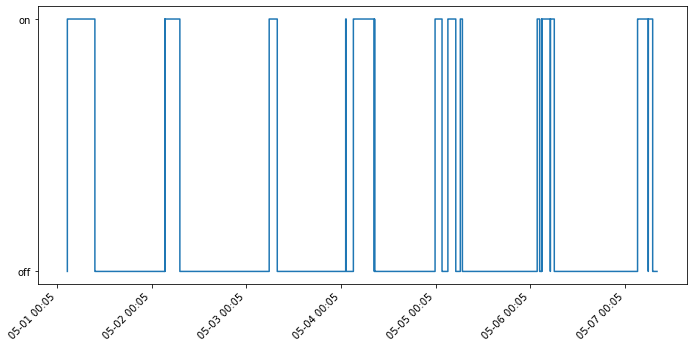

In [ ]:
plot_cycle(power_values)

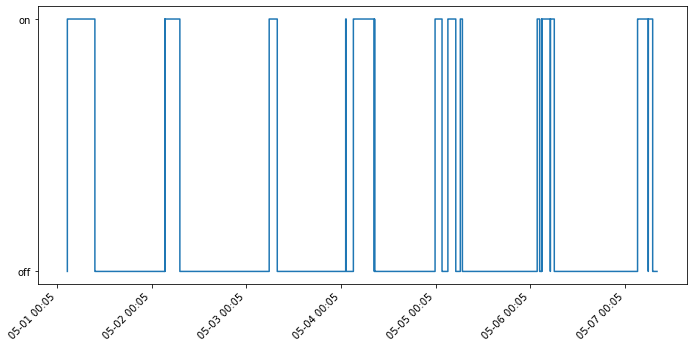

In [ ]:
plot_cycle(power_values_1)

In [ ]:
from pytz import timezone
import pytz
import datetime

### Plot intervals usage based on state change in the bulb (ON to OFF or vice versa)
def get_power_intervals(power_values):
  intervals = []
  cycle = power_values['value'][0]
  start = power_values['timestamp'][0]

  for value, timestamp in zip(power_values['value'][1:], power_values['timestamp'][1:]):
    if value != cycle:
      duration = timestamp - start
      duration = round(duration.total_seconds() / 60 / 60, 2)
      
      #converting utc to pdt  - { 'start': start.strftime("%m/%d/%Y, %H:%M:%S"),
      start_date = start.astimezone(timezone('US/Pacific'))
      end_date = timestamp.astimezone(timezone('US/Pacific'))

      intervals.append({ 'start': start_date.strftime('%m/%d/%Y %H:%M:%S %Z'),
                         'end': end_date.strftime('%m/%d/%Y %H:%M:%S %Z'),
                         'from': cycle,
                         'to': value,
                         'duration': duration})
      cycle = value
      start = timestamp

  return pd.DataFrame(intervals)

When are light tpyically turned on?
How long are lights typically on for?

In [ ]:
intervals = get_power_intervals(power_values)

In [ ]:
on = intervals.where(intervals['from'] == 'off')
on = on.where(intervals['to'] == 'on')
on.dropna(inplace=True)
on

,start,end,from,to,duration
0,04/30/2021 19:38:01 PDT,04/30/2021 19:39:00 PDT,off,on,0.02
2,05/01/2021 02:38:01 PDT,05/01/2021 20:22:01 PDT,off,on,17.73
4,05/01/2021 20:23:01 PDT,05/01/2021 20:24:01 PDT,off,on,0.02
6,05/02/2021 22:49:01 PDT,05/02/2021 22:50:01 PDT,off,on,0.02
8,05/03/2021 18:13:00 PDT,05/03/2021 18:14:00 PDT,off,on,0.02
10,05/03/2021 18:22:00 PDT,05/03/2021 20:11:01 PDT,off,on,1.82
12,05/04/2021 01:31:01 PDT,05/04/2021 01:32:01 PDT,off,on,0.02
14,05/04/2021 01:33:01 PDT,05/04/2021 16:54:01 PDT,off,on,15.35
16,05/04/2021 18:40:01 PDT,05/04/2021 20:09:01 PDT,off,on,1.48
18,05/04/2021 23:17:01 PDT,05/04/2021 23:18:00 PDT,off,on,0.02


In [ ]:
print ('Min time on {0} hours'.format(on['duration'].min()))
print ('Max time on {0} hours'.format(on['duration'].max()))
print ('Avg time on {0} hours'.format(round(on['duration'].mean(), 2)))

Min time on 0.02 hours
Max time on 21.12 hours
Avg time on 4.82 hours


### Lights were turned on in the morning around 7 AM
### They were left on for 14 hours
### On average lights were on for 1.91 hours
### Min time lights were left on was 1.2 minutes


When were the lights turned off?

In [ ]:
off = intervals.where(intervals['from'] == 'on')
off = off.where(intervals['to'] == 'off')
off.dropna(inplace=True)
off

,start,end,from,to,duration
1,04/30/2021 19:39:00 PDT,05/01/2021 02:38:01 PDT,on,off,6.98
3,05/01/2021 20:22:01 PDT,05/01/2021 20:23:01 PDT,on,off,0.02
5,05/01/2021 20:24:01 PDT,05/02/2021 22:49:01 PDT,on,off,26.42
7,05/02/2021 22:50:01 PDT,05/03/2021 18:13:00 PDT,on,off,19.38
9,05/03/2021 18:14:00 PDT,05/03/2021 18:22:00 PDT,on,off,0.13
11,05/03/2021 20:11:01 PDT,05/04/2021 01:31:01 PDT,on,off,5.33
13,05/04/2021 01:32:01 PDT,05/04/2021 01:33:01 PDT,on,off,0.02
15,05/04/2021 16:54:01 PDT,05/04/2021 18:40:01 PDT,on,off,1.77
17,05/04/2021 20:09:01 PDT,05/04/2021 23:17:01 PDT,on,off,3.13
19,05/04/2021 23:18:00 PDT,05/04/2021 23:50:01 PDT,on,off,0.53


## What's the average brightness
### In terms of lumens? Ex: 50% = 50% of the total lumens available?
### Fluctuated between 0 and 0.8
### Approximately followed power cycle

In [ ]:
brightness = get_field_values_from_flux('brightness', 0)

from(bucket: "SmartBulbData") |> range(start: -7d) |> filter(fn:(r) => r._field == "brightness" )


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Num tables 2

Num records in table 4041
Sample record brightness, 0.0

Num records in table 4039
Sample record brightness, 0.0

Extracted 4041 values
Sample {'timestamp': datetime.datetime(2021, 5, 1, 2, 38, 1, tzinfo=tzlocal()), 'year': 2021, 'month': 5, 'day': 1, 'hour': 2, 'minute': 38, 'value': 0.0}

Earliest: 2021-05-01 02:38:01+00:00
Latest: 2021-05-07 08:10:04+00:00


In [ ]:
# ON = 75% brightness
brightness['value'].describe()

count    3827.000000
mean        0.436997
std         0.369149
min         0.000000
25%         0.122900
50%         0.200000
75%         1.000000
max         1.000000
Name: value, dtype: float64

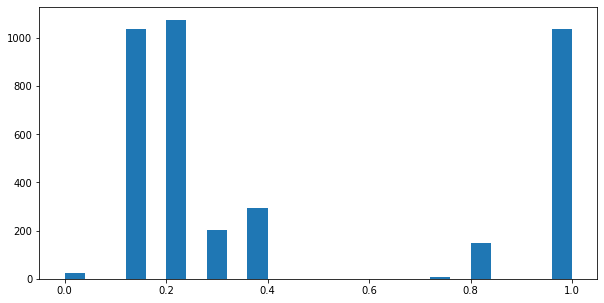

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as dates

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(brightness['value'], bins=25)
plt.show()

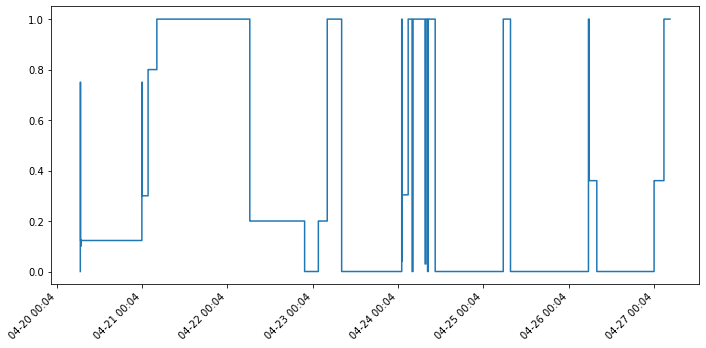

In [ ]:
plot_cycle(brightness)

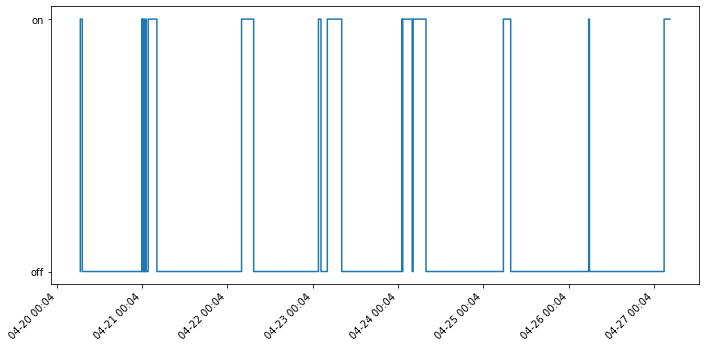

In [ ]:
plot_cycle(power_values)